In [1]:
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import spconv.pytorch as spconv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
with h5py.File('train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']

    val_data = []

    data = []
    for i, event in enumerate(label_events):
        if i < 500:
            val_data.append(f['data'][i].reshape(-1,4))
            continue
        
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)
    
#     n_signal_events = 0
    
#     n_michel_voxels = np.zeros(len(label_events))

#     # Iterate and print each event (which is a variable-length array)
#     for i, event in enumerate(label_events):
#         print(f"Event {i}: {event} (length = {len(event)})")
#         n_signal_events += np.any(event == 2)
#         n_michel_voxels[i] = np.sum(event == 2)

# # Corrected the misplaced parenthesis in the print statement
# print("Fraction of events with Michel electrons:", (n_signal_events / len(label_events)) * 100, "%")

In [4]:
# Open the labels file
with h5py.File('train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []
    val_labels = []

    for i, event in enumerate(label_events):
        if i < 500:
            val_labels.append(event)
            continue
    
        labels.append(event)

In [5]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
val_truth = [(event_labels == 2).astype(np.int32) for event_labels in val_labels]

In [ ]:
fig, ax = plt.subplots(layout="constrained")
ax.hist(ak.num(data), bins=100)
ax.grid()
ax.set(xlabel="Number of points per event", ylabel="Counts")

[Text(0.5, 0, 'Label'), Text(0, 0.5, 'Counts')]

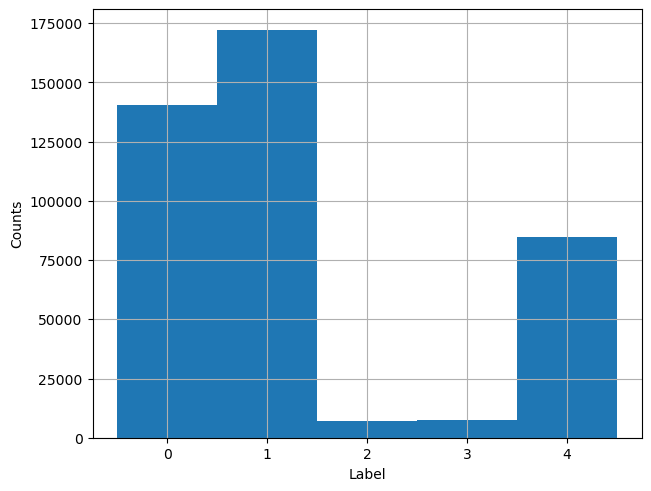

In [5]:
# Plot the types of labels
fig, ax = plt.subplots(layout="constrained")
ax.hist(ak.flatten(labels), bins=np.arange(0, 6)-0.5)
ax.grid()
ax.set(xlabel="Label", ylabel="Counts")

Text(0.5, 0, 'z')

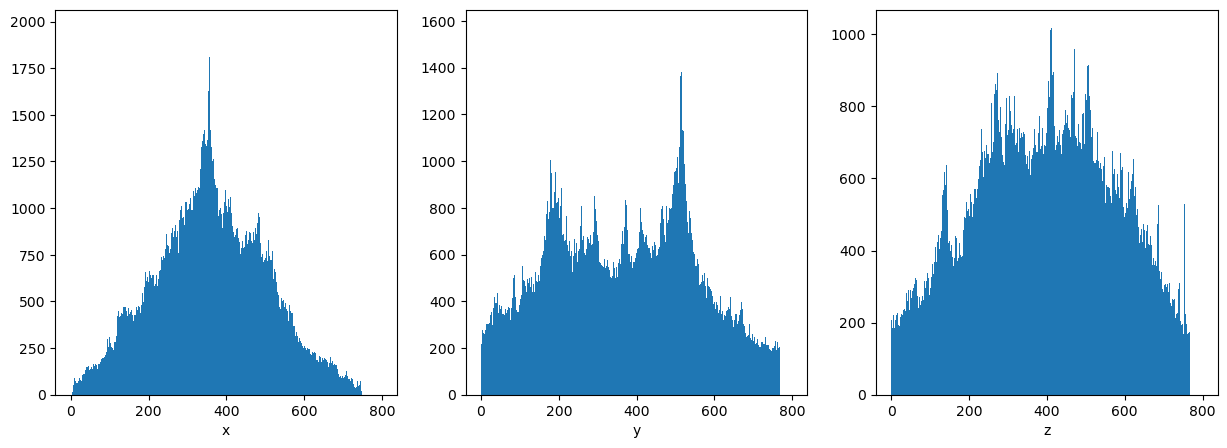

In [6]:
# plot in the x, y, z dimensions
fig, axcs = plt.subplots(1, 3, figsize=(15, 5))
axcs[0].hist(ak.flatten(data[:, :, 0]), bins=np.arange(0, 800))
axcs[0].set_xlabel('x')
axcs[1].hist(ak.flatten(data[:, :, 1]), bins=np.arange(800))
axcs[1].set_xlabel('y')
axcs[2].hist(ak.flatten(data[:, :, 2]), bins=np.arange(800))
axcs[2].set_xlabel('z')

In [5]:
np.min(data[:, :, 0]), np.max(data[:, :, 0]), \
np.min(data[:, :, 1]), np.max(data[:, :, 1]), \
np.min(data[:, :, 2]), np.max(data[:, :, 2])

(np.float64(2.0),
 np.float64(748.0),
 np.float64(0.0),
 np.float64(767.0),
 np.float64(0.0),
 np.float64(767.0))

In [6]:
# Input: sparse tensor with coordinates and features
# coordinates: Nx4 tensor (batch_idx, x, y, z)
# features: Nx1 tensor (voxel values)
# Iterate over the events and create sparse tensors
# Example input data

features = []
coords = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, input_event in enumerate(data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    features.append(input_feats)
    coords.append(input_coords)

val_features = []
val_coords = []
for i, input_event in enumerate(val_data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    val_features.append(input_feats)
    val_coords.append(input_coords)

In [7]:
input_feats = torch.cat(features, dim=0).to(device)
input_coords = torch.cat(coords, dim=0).to(device)

val_input_feats = torch.cat(val_features, dim=0).to(device)
val_input_coords = torch.cat(val_coords, dim=0).to(device)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.encoder = spconv.SparseSequential(
            # TODO try submanifold convolution
            spconv.SparseConv3d(1, 2, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
            spconv.SparseConv3d(2, 3, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            # TODO maxpooling
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            # TODO batch normalization
            nn.BatchNorm3d(3),
            nn.ReLU(),
            spconv.SparseConv3d(3, 4, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp2"),
            spconv.SparseConv3d(4, 5, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp3"),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm3d(5),
            nn.ReLU(),
        ).to(device)

        self.decoder = spconv.SparseSequential(
            spconv.SparseInverseConv3d(5, 4, 3, algo=spconv.ConvAlgo.Native, indice_key="cp3"), 
            spconv.SparseInverseConv3d(4, 3, 3, algo=spconv.ConvAlgo.Native, indice_key="cp2"), 
            nn.BatchNorm3d(3),
            nn.ReLU(),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            # nn.ReLU(),
            spconv.SparseInverseConv3d(3, 2, 3, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            spconv.SparseInverseConv3d(4, 1, 3, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
        )
        self.shape = shape

    def forward(self, features, coors, batch_size):
        coors = coors.int()
        x = spconv.SparseConvTensor(features, coors, self.shape, batch_size)

        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AutoEncoder([767, 767, 767]).to(device)

In [ ]:
# train model using the truth labels
n_voxels = ak.num(truth)
n_voxels_cumsum = np.cumsum(n_voxels)

n_epochs = 5
loss_per_epoch = np.zeros(n_epochs)
val_loss_per_epoch = np.zeros(n_epochs)

loss_fn = nn.BCEWithLogitsLoss()

batch_size = 5  # Define batch size
for epoch in range(n_epochs):  # Example training loop
    batch_indices = range(0, len(data), batch_size)
    loss_per_batch = np.zeros(len(batch_indices))

    for i, batch in enumerate(tqdm(batch_indices)):  # Batch size of 5
        voxel_i_lower = 0 if batch == 0 else n_voxels_cumsum[batch - 1]
        voxel_i_upper = n_voxels_cumsum[batch + batch_size-1] if (batch + batch_size-1) < len(data) else n_voxels_cumsum[-1]

        batch_input_feats = input_feats[voxel_i_lower:voxel_i_upper]
        batch_input_coords = input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
        # From batch_input_coords, subtract the batch number to make indices start from 0
        batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch

        # Defensive: skip if batch_input_coords is empty
        if batch_input_coords.shape[0] == 0:
            print("Empty batch. Skip")
            continue

        # Defensive: check max batch index only if not empty
        if batch_input_coords.shape[0] > 0:
            assert batch_input_coords[:, 0].max().item() == batch_size - 1, batch_input_coords[:, 0].max().item()
            assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()

        batch_truth = torch.tensor(ak.flatten(truth[batch:batch+batch_size]), dtype=torch.float32).unsqueeze(1).to(device)

        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer.zero_grad()
        output_sparse = model(batch_input_feats, batch_input_coords, batch_size=batch_size)
        loss = loss_fn(output_sparse.features, batch_truth)
        loss.backward()
        optimizer.step()
        loss_per_batch[i] = loss.detach().clone().item()

        # break  # Remove this break to run on all batches
    
    # TODO Calculate the loss for validation data
    # model.eval()
    # output_sparse = model(val_input_feats, val_input_coords, batch_size=val_input_feats[:, 0].max())
    # val_loss_per_epoch[epoch] = loss_fn(output_sparse, val_truth)
    # Save the loss
    loss_per_epoch[epoch] = np.mean(loss_per_batch)
    # Save a copy of the model every epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")


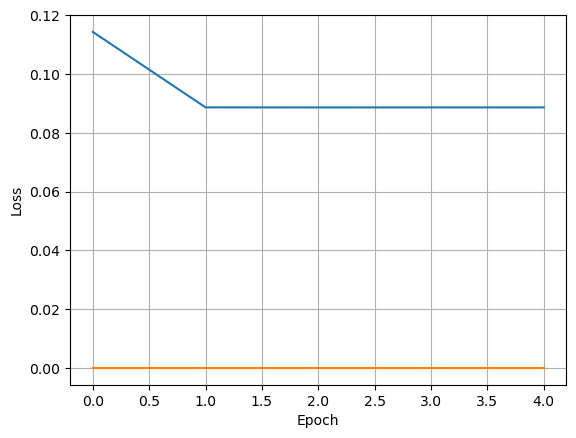

In [19]:
plt.plot(range(n_epochs), loss_per_epoch)
plt.plot(range(n_epochs), val_loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [ ]:
# Calculate the F1 score:
from sklearn.metrics import f1_score
